In [383]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
location = (49.5, 19.2, 'Mútne', 830)
def get_data(location):
    latitude, longitude, name, altitude = location
    out = pvlib.iotools.get_pvgis_tmy(latitude, longitude, map_variables=True)
    weather = out[0]
    weather.index = weather.index.map(lambda x: x.replace(year=2016))
    return weather

weather = get_data(location)

In [384]:
weather.head()

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2016-01-01 00:00:00+00:00,-8.89,84.97,0.0,0.0,0.0,229.54,2.59,210.0,93353.0
2016-01-01 01:00:00+00:00,-9.12,83.75,0.0,0.0,0.0,222.23,2.56,210.0,93325.0
2016-01-01 02:00:00+00:00,-9.34,82.52,0.0,0.0,0.0,214.92,2.53,210.0,93298.0
2016-01-01 03:00:00+00:00,-9.57,81.29,0.0,0.0,0.0,207.61,2.49,215.0,93277.0
2016-01-01 04:00:00+00:00,-9.79,80.06,0.0,0.0,0.0,200.31,2.46,220.0,93256.0


In [385]:
latitude, longitude, name, altitude = location
location = pvlib.location.Location(latitude=latitude,
                                   longitude=longitude)

In [386]:
times = weather.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
solar_position.index += pd.Timedelta('30min')

In [472]:
tilt = 45
azimuth = 180


irradiance = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                       surface_azimuth=azimuth,
                                                       dni=weather['dni'],
                                                       ghi=weather['ghi'],
                                                       dhi=weather['dhi'],
                                                       solar_zenith=solar_position['apparent_zenith'],
                                                       solar_azimuth=solar_position['azimuth'])


In [473]:
def get_month(data, month):
    return data[data.index.month==month]

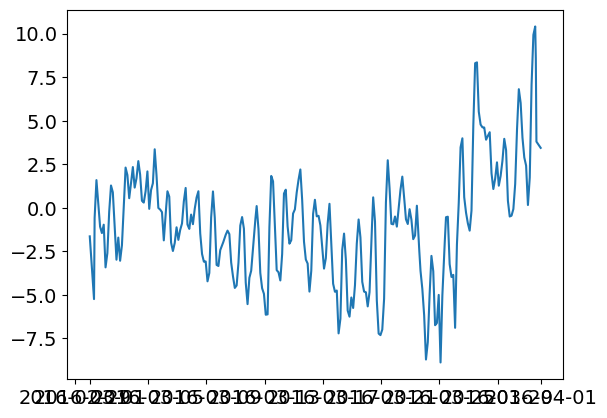

In [474]:
plt.plot(get_month(weather, 3)['temp_air'])

In [475]:
parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(irradiance["poa_global"],
                                               weather['temp_air'],
                                               weather['wind_speed'],
                                               **parameters)

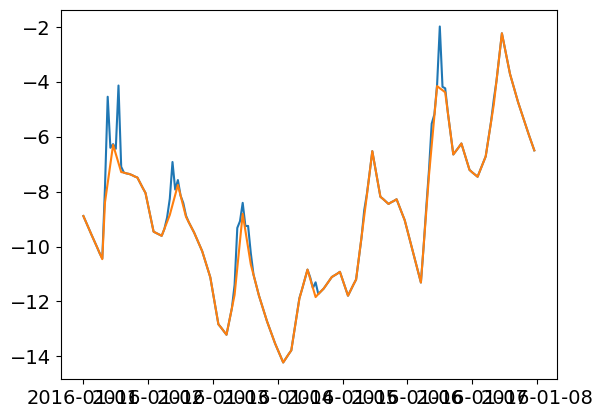

In [476]:
plt.plot(get_month(cell_temperature, 1).head(24*7))
plt.plot(get_month(weather, 1).head(24*7)["temp_air"])

In [477]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 4.2

array_power = pvlib.pvsystem.pvwatts_dc(irradiance["poa_global"], cell_temperature, nameplate, gamma_pdc)

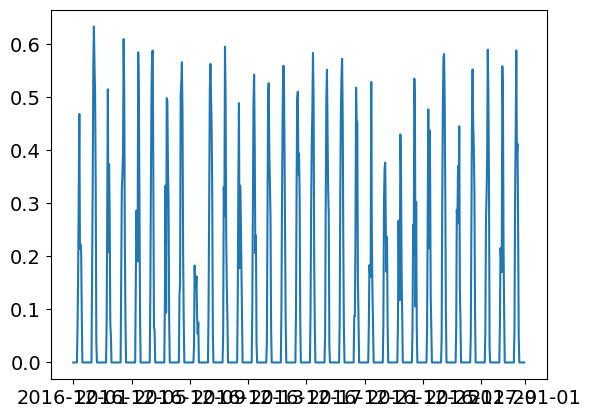

In [478]:
plt.plot(get_month(array_power,12))

In [479]:
pdc0 = 800/0.96  # W
ac = pvlib.inverter.pvwatts(array_power, pdc0)

In [480]:
ac

time(UTC)
2016-01-01 00:00:00+00:00    0.0
2016-01-01 01:00:00+00:00    0.0
2016-01-01 02:00:00+00:00    0.0
2016-01-01 03:00:00+00:00    0.0
2016-01-01 04:00:00+00:00    0.0
                            ... 
2016-12-31 19:00:00+00:00    0.0
2016-12-31 20:00:00+00:00    0.0
2016-12-31 21:00:00+00:00    0.0
2016-12-31 22:00:00+00:00    0.0
2016-12-31 23:00:00+00:00    0.0
Length: 8760, dtype: float64

In [481]:
def plot_day(array_power, month, day):
    plt.rcParams['font.size'] = 14
    vals = get_month(array_power, month)[(day*24)-24:day*24].values
    plt.plot(vals, label=month)
    plt.title('AC Power')
    plt.ylabel('Output [Wh/day]')
    plt.grid()
    plt.legend()

In [482]:
get_month(array_power, 12)[(22*24)-24:22*24]

time(UTC)
2016-12-22 00:00:00+00:00    0.000000
2016-12-22 01:00:00+00:00    0.000000
2016-12-22 02:00:00+00:00    0.000000
2016-12-22 03:00:00+00:00    0.000000
2016-12-22 04:00:00+00:00    0.000000
2016-12-22 05:00:00+00:00    0.000000
2016-12-22 06:00:00+00:00    0.000000
2016-12-22 07:00:00+00:00    0.073739
2016-12-22 08:00:00+00:00    0.300941
2016-12-22 09:00:00+00:00    0.364927
2016-12-22 10:00:00+00:00    0.376379
2016-12-22 11:00:00+00:00    0.251156
2016-12-22 12:00:00+00:00    0.170877
2016-12-22 13:00:00+00:00    0.236296
2016-12-22 14:00:00+00:00    0.069677
2016-12-22 15:00:00+00:00    0.000000
2016-12-22 16:00:00+00:00    0.000000
2016-12-22 17:00:00+00:00    0.000000
2016-12-22 18:00:00+00:00    0.000000
2016-12-22 19:00:00+00:00    0.000000
2016-12-22 20:00:00+00:00    0.000000
2016-12-22 21:00:00+00:00    0.000000
2016-12-22 22:00:00+00:00    0.000000
2016-12-22 23:00:00+00:00    0.000000
dtype: float64

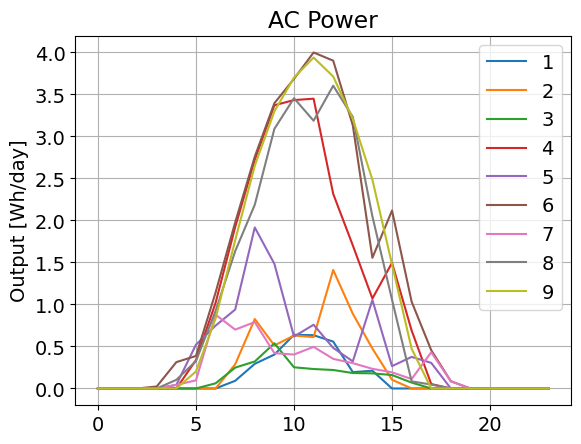

In [483]:
plot_day(array_power, 1, 15)
plot_day(array_power, 2, 15)
plot_day(array_power, 3, 15)
plot_day(array_power, 4, 15)
plot_day(array_power, 5, 15)
plot_day(array_power, 6, 15)
plot_day(array_power, 7, 15)
plot_day(array_power, 8, 15)
plot_day(array_power, 9, 15)
plot_day(array_power, 10, 15)
plot_day(array_power, 11, 15)
plot_day(array_power, 12, 15)
